In [120]:
import torch
import numpy as np 
import matplotlib.pyplot as plt

from DC3D_V3.Helper_files.Image_Metrics import *
from DC3D_V3.Helper_files.ExecutionTimer import Execution_Timer



In [121]:
from torchmetrics.functional import structural_similarity_index_measure as ssimlocal


# Nomalised Root Mean Squared Error (NMSRE)
def NMSRE2(clean_input, noised_target):
    inp = clean_input.detach().numpy()
    tar = noised_target.detach().numpy()
    norm_rootmnsq = normalized_root_mse(inp, tar)
    return float(norm_rootmnsq)

#Signal to Noise Ratio (SNR)

def SNR2(clean_inputs, noised_targets):
    """
    Calculates the average Signal to Noise Ratio (SNR) for a batch of clean signals and noisy signals.
    SNR is defined as the ratio of the magnitude of the signal and the magnitude of the noise.
    
    Args:
    clean_inputs (torch.Tensor): The original signals with shape (batch_size, ...).
    noised_targets (torch.Tensor): The signals with added noise with shape (batch_size, ...).
    
    Returns:
    float: The average SNR value for the batch in db.
    """
    # Calculate signal power
    signal_power = torch.mean(torch.pow(clean_inputs, 2), dim=tuple(range(1, clean_inputs.dim())))
    
    # Calculate noise power
    noise = clean_inputs - noised_targets
    noise_power = torch.mean(torch.pow(noise, 2), dim=tuple(range(1, clean_inputs.dim())))
    
    # Calculate SNR for each example in the batch
    snr = 10 * torch.log10(signal_power / noise_power)
    
    # Calculate and return the average SNR across the batch
    average_snr = torch.mean(snr)
    
    return float(average_snr.cpu().numpy())

#Peak Signal-to-Noise Ratio (PSNR):
def PSNR2(clean_input, noised_target, time_dimension, normalised=True):
    """
    Calculates the average Peak Signal to Noise Ratio (PSNR) for a batch of clean and noisy signals.
    PSNR is defined as the ratio of the maximum possible power of a signal and the power of corrupting noise.

    Args:
    clean_inputs (torch.Tensor): The original signals with shape (batch_size, ...).
    noised_targets (torch.Tensor): The noisy signals with shape (batch_size, ...).
    time_dimension (float): The maximum possible value of the signal. # ACTUALLY AS IN NORMALISED SPACE THIS SHOULD BE SET TO 1???

    Returns:
    float: The average PSNR value for the batch.
    """
    if normalised:
        time_dimension = 1.0 # ACTUALLY AS IN NORMALISED SPACE THIS SHOULD BE SET TO 1?

    # Calculate mean square error (MSE) for each example in the batch
    mse = torch.mean(torch.pow(clean_input - noised_target, 2), dim=tuple(range(1, clean_input.dim())))
    
    # Calculate PSNR for each example in the batch
    psnr = 10 * torch.log10((time_dimension ** 2) / mse)
    
    # Calculate and return the average PSNR across the batch
    average_psnr = torch.mean(psnr)
    
    return float(average_psnr.cpu().numpy())

#Mean Squared Error (MSE):
def MSE2(clean_input, noised_target):
    """
    Mean Squared Error (MSE)

    Args:
    clean_input (torch.Tensor): The original image.
    noised_target (torch.Tensor): The recovered image.
    
    Returns:
    The calculated Mean Squared Error value.
    """
    mse = torch.mean((clean_input - noised_target) ** 2)
    return mse.item()

#Mean Absolute Error (MAE):
def MAE2(clean_input, noised_target):
    """
    Mean Absolute Error (MAE)

    Args:
    clean_input (torch.Tensor): The original image.
    noised_target (torch.Tensor): The recovered image.
    
    Returns:
    The calculated Mean Absolute Error value.
    """
    return torch.mean(torch.abs(clean_input - noised_target)).item()

#Structural Similarity Index (SSIM):
def SSIM2(clean_input, noised_target, time_dimension, normalised=True):
    """
    Structural Similarity Index Measure (SSIM), is a perceptual quality index that measures the structural similarity between 
    two images. SSIM takes into account the structural information of an image, such as luminance, contrast, and structure, 
    and compares the two images based on these factors. SSIM is based on a three-part similarity metric that considers the 
    structural information in the image, the dynamic range of the image, and the luminance information of the image. SSIM is 
    designed to provide a more perceptually relevant measure of image similarity than traditional metrics such as Mean Squared 
    Error or Peak Signal-to-Noise Ratio.

    Args:
    clean_input (torch.Tensor): The original image.
    noised_target (torch.Tensor): The recovered image.
    
    Returns:
    The calculated Structural Similarity Index Measure value.
    """
    if normalised:
        time_dimension = 1.0
    else:
        time_dimension = float(time_dimension)
    
    return ssimlocal(clean_input, noised_target, data_range=time_dimension).item()

#Correlation Coefficent
def correlation_coeff2(clean_input, noised_target):
    
    """
    Correlation coefficient is a scalar value that measures the linear relationship between two signals. The correlation 
    coefficient ranges from -1 to 1, where a value of 1 indicates a perfect positive linear relationship, a value of -1 indicates 
    a perfect negative linear relationship, and a value of 0 indicates no linear relationship between the two signals. Correlation 
    coefficient only measures the linear relationship between two signals, and does not take into account the structure of the signals.

    ρ = cov(x,y) / (stddev(x) * stddev(y))

    The function first computes the mean and standard deviation of each tensor, and then subtracts the mean from each element 
    to get the centered tensors x_center and y_center. The numerator is the sum of the element-wise product of x_center 
    and y_center, and the denominator is the product of the standard deviations of the two centered tensors multiplied by the 
    number of elements in the tensor. The function returns the value of the correlation coefficient ρ as the ratio of the numerator 
    and denominator.

    Args:
    clean_input (torch.Tensor): The original image.
    noised_target (torch.Tensor): The recovered image.
    
    Returns:
    The calculated correlation coefficient value.
    """
    clean_mean = clean_input.mean()
    noised_mean = noised_target.mean()
    clean_std = clean_input.std(unbiased=False)  # unbiased=False for consistent calculation of std deviations
    noised_std = noised_target.std(unbiased=False)  
    
    clean_centered = clean_input - clean_mean
    noised_centered = noised_target - noised_mean
    
    numerator = (clean_centered * noised_centered).sum()
    denominator = clean_std * noised_std * clean_input.numel()
    
    return float((numerator / denominator).item())

#Mutual Information:
def NomalisedMutualInformation2(clean_input, noised_target):
    clean_image = clean_input.numpy()
    recovered_image = noised_target.numpy()
    return normalized_mutual_information(clean_image, recovered_image)-1 # ???? -1 ???? 

def compare_images_pixels2(target_image, reconstructed_image, debug_mode=False): 
    """
    Takes in the clean image and the denoised image and compares them to find the percentages of signal spatial retention, signal temporal retention, and the raw count of false positives and false negatives.

    Args:
        target_image (torch tensor): The clean image
        reconstructed_image (torch tensor): The denoised image
        debug_mode (bool): If True, the function will print out the total number of pixels, the true signal points, and the true zero points in the target image. Default = False
        
    Returns:
        signal_spatial_retention_percentage (float): The percentage of signal spatial retention
        signal_temporal_retention_percentage (float): The percentage of signal temporal retention
        false_positive_count_raw (int): The raw count of false positives
        false_negative_count_raw (int): The raw count of false negatives
    """
    
    # determine the total number of pixels in the data
    total_pixels = target_image.numel()
    if debug_mode:
        print("Total Pixels: ", total_pixels)

    # Genrates a index mask for the zero values in the target image
    zero_mask = (target_image == 0)

    # Inverts the zero mask to get the non-zero mask from the target image indicating the signal points
    nonzero_mask = ~zero_mask

    # True Number of Signal Points in the Target Image
    true_signal_points = len(target_image[nonzero_mask])
    if debug_mode:
        print("True Signal Points: ", true_signal_points)

    # True Zero Points in the Target Image
    true_zero_points = len(target_image[zero_mask])
    if debug_mode:
        print("True Zero Points: ", true_zero_points)


    # detemine how many of the values in the reconstructed image that fall in the nonzero mask are non zero
    signal_spatial_retention_raw = len(reconstructed_image[nonzero_mask].nonzero())
    if debug_mode:
        print("Signal Spatial Retention Raw: ", signal_spatial_retention_raw)
    signal_spatial_retention_percentage = (signal_spatial_retention_raw / len(reconstructed_image[nonzero_mask])) * 100
    if debug_mode:
        print("Signal Spatial Retention Percentage: ", signal_spatial_retention_percentage, "%")

    # determine how many of those indexs have matching ToF values
    values_in_recon = reconstructed_image[nonzero_mask]
    values_in_target = target_image[nonzero_mask]
    signal_temporal_retention_raw = len(values_in_recon[values_in_recon == values_in_target])
    if debug_mode:
        print("Signal Temporal Retention Raw: ", signal_temporal_retention_raw)
    signal_temporal_retention_percentage = (signal_temporal_retention_raw / len(reconstructed_image[nonzero_mask])) * 100
    if debug_mode:
        print("Signal Temporal Retention Percentage: ", signal_temporal_retention_percentage, "%")


    # determine how many of the values in the reconstructed image that fall under the zero mask are not zero 
    false_positive_count_raw = len(reconstructed_image[zero_mask].nonzero())
    if debug_mode:
        print("False Positive Count: ", false_positive_count_raw)


    # Determine how many of the values in the reconstructed image that fall under the non zero mask are zero
    data = reconstructed_image[nonzero_mask]
    false_negative_count_raw = len(data[data == 0])
    if debug_mode:
        print("False negative count: ", false_negative_count_raw)

    return signal_spatial_retention_percentage, signal_temporal_retention_percentage, false_positive_count_raw, false_negative_count_raw













In [122]:
#Combine all performance metrics into simple test script
def quantify_loss_performanceOLD(clean_input_batch, noised_target_batch, time_dimension):
    """
    This function compares each image in the batch to its corresponding target image and calculates a range of enhanced performance metrics for each. The results for each metric are then avaeraged over the batch and this average is appended to the corresponding list of average metrics results for each epoch which is tracked eleshwehre in the enhanced performance tracking system

    Args:
        clean_input_batch (torch tensor): The input image batch. Shape [B, C, H, W]
        noised_target_batch (torch tensor): The target image batch. Shape [B, C, H, W]
        time_dimension (int): The number of time steps in the data set, used to set the upper limit of the noise point values. Default = 100  
    
    Generates:
        Appends the average performance metrics for the batch to the corresponding list of average metrics results for each epoch which is tracked eleshwehre in the enhanced performance tracking system and needs simplifying and condensing!!!

    """
    loss_mse = []
    loss_mae = []
    loss_snr = []
    loss_psnr = []
    loss_ssim = []
    loss_nmi = []
    loss_cc = []
    loss_true_positive_xy = []
    loss_true_positive_tof = []
    loss_false_positive_xy = [] 
    #loss_false_negative_xy = []
    #loss_nrmse = []

    for i in range(len(clean_input_batch)): # iterates through batch 
        clean_input = clean_input_batch[i][0] # removes channel dim 
        noised_target = noised_target_batch[i][0]

        # Appends the performance metrics for each image in the batch to the corresponding list of metrics results for each epoch
        #loss_nrmse.append(NMSRE(clean_input, noised_target))
        timer.record_time(event_name="MSE", event_type="start")
        loss_mse.append(MSE(clean_input, noised_target))
        timer.record_time(event_name="MSE", event_type="stop")

        timer.record_time(event_name="MAE", event_type="start")
        loss_mae.append(MAE(clean_input, noised_target))
        timer.record_time(event_name="MAE", event_type="stop")

        timer.record_time(event_name="SNR", event_type="start")
        loss_snr.append(SNR(clean_input, noised_target))
        timer.record_time(event_name="SNR", event_type="stop")

        timer.record_time(event_name="PSNR", event_type="start")
        loss_psnr.append(PSNR(clean_input, noised_target, time_dimension))
        timer.record_time(event_name="PSNR", event_type="stop")

        timer.record_time(event_name="SSIM", event_type="start")
        loss_ssim.append(SSIM(clean_input, noised_target, time_dimension))
        timer.record_time(event_name="SSIM", event_type="stop")

        timer.record_time(event_name="NMI", event_type="start")
        loss_nmi.append(NomalisedMutualInformation(clean_input, noised_target))
        timer.record_time(event_name="NMI", event_type="stop")

        timer.record_time(event_name="CC", event_type="start")
        loss_cc.append(correlation_coeff(clean_input, noised_target))
        timer.record_time(event_name="CC", event_type="stop")

        timer.record_time(event_name="Compare Images", event_type="start")
        percentage_of_true_positive_xy, percentage_of_true_positive_tof, numof_false_positives_xy, num_false_negative_xy = compare_images_pixels(clean_input, noised_target)
        loss_true_positive_xy.append(percentage_of_true_positive_xy)
        loss_true_positive_tof.append(percentage_of_true_positive_tof)
        loss_false_positive_xy.append(numof_false_positives_xy)
        #loss_false_negative_xy.append(num_false_negative_xy)
        timer.record_time(event_name="Compare Images", event_type="stop")

    # Calculates the mean of the performance metrics for the batch and appends this to the corresponding list of average metrics results for each epoch
    
    timer.record_time(event_name="AVERAGING PROCESSING", event_type="start")
    #avg_loss_nrmse.append(np.mean(loss_nrmse))
    avg_loss_mse.append(np.mean(loss_mse))
    avg_loss_mae.append(np.mean(loss_mae))
    avg_loss_snr.append(np.mean(loss_snr))
    avg_loss_psnr.append(np.mean(loss_psnr))
    avg_loss_ssim.append(np.mean(loss_ssim))
    avg_loss_nmi.append(np.mean(loss_nmi))
    avg_loss_cc.append(np.mean(loss_cc))
    avg_loss_true_positive_xy.append(np.mean(loss_true_positive_xy))
    avg_loss_true_positive_tof.append(np.mean(loss_true_positive_tof))
    avg_loss_false_positive_xy.append(np.mean(loss_false_positive_xy))
    #avg_loss_false_negative_xy.append(np.mean(loss_false_negative_xy)

    timer.record_time(event_name="AVERAGING PROCESSING", event_type="stop")



In [123]:
def quantify_loss_performance(clean_input_batch, noised_target_batch, time_dimension):
    """
    This function compares each image in the batch to its corresponding target image and calculates a range of enhanced performance metrics for each. The results for each metric are then avaeraged over the batch and this average is appended to the corresponding list of average metrics results for each epoch which is tracked eleshwehre in the enhanced performance tracking system

    Args:
        clean_input_batch (torch tensor): The input image batch. Shape [B, C, H, W]
        noised_target_batch (torch tensor): The target image batch. Shape [B, C, H, W]
        time_dimension (int): The number of time steps in the data set, used to set the upper limit of the noise point values. Default = 100  
    
    Generates:
        Appends the average performance metrics for the batch to the corresponding list of average metrics results for each epoch which is tracked eleshwehre in the enhanced performance tracking system and needs simplifying and condensing!!!

    """


    batch_size = len(clean_input_batch)

    # Calculates the mean of the performance metrics for the batch and appends this to the corresponding list of average metrics results for each epoch
    #avg_loss_nrmse.append(np.mean(loss_nrmse))
    timer.record_time(event_name="MSE2", event_type="start")
    avg_loss_mse.append(MSE2(clean_input_batch.squeeze(1), noised_target_batch.squeeze(1)))
    timer.record_time(event_name="MSE2", event_type="stop")

    timer.record_time(event_name="MAE2", event_type="start")
    avg_loss_mae.append(MAE2(clean_input_batch.squeeze(1), noised_target_batch.squeeze(1)))
    timer.record_time(event_name="MAE2", event_type="stop")

    timer.record_time(event_name="SNR2", event_type="start")
    avg_loss_snr.append(SNR2(clean_input_batch.squeeze(1), noised_target_batch.squeeze(1)))
    timer.record_time(event_name="SNR2", event_type="stop")

    timer.record_time(event_name="PSNR2", event_type="start")
    avg_loss_psnr.append(PSNR2(clean_input_batch.squeeze(1), noised_target_batch.squeeze(1), time_dimension))
    timer.record_time(event_name="PSNR2", event_type="stop")

    timer.record_time(event_name="SSIM2", event_type="start")
    avg_loss_ssim.append(SSIM2(clean_input_batch, noised_target_batch, time_dimension))
    timer.record_time(event_name="SSIM2", event_type="stop")

    timer.record_time(event_name="NMI2", event_type="start")
    avg_loss_nmi.append(NomalisedMutualInformation2(clean_input_batch.squeeze(1), noised_target_batch.squeeze(1)))
    timer.record_time(event_name="NMI2", event_type="stop")

    timer.record_time(event_name="CC2", event_type="start")
    avg_loss_cc.append(correlation_coeff2(clean_input_batch.squeeze(1), noised_target_batch.squeeze(1)))
    timer.record_time(event_name="CC2", event_type="stop")

    timer.record_time(event_name="compare_images_pixels2", event_type="start")
    percentage_of_true_positive_xy, percentage_of_true_positive_tof, numof_false_positives_xy, num_false_negative_xy = compare_images_pixels2(clean_input_batch.squeeze(1), noised_target_batch.squeeze(1))    
    avg_loss_true_positive_xy.append(percentage_of_true_positive_xy)
    avg_loss_true_positive_tof.append(percentage_of_true_positive_tof)
    avg_loss_false_positive_xy.append(numof_false_positives_xy / batch_size)
    #avg_loss_false_negative_xy.append(loss_false_negative_xy / batch_size)
    timer.record_time(event_name="compare_images_pixels2", event_type="stop")



c:\Users\Ada\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Event: Begining, Average time: 1.6008832000079565, Total time: 1.6008832000079565
Event: MSE2, Average time: 0.0003510749986162409, Total time: 0.007021499972324818
Event: MAE2, Average time: 0.0002815900021232665, Total time: 0.005631800042465329
Event: SNR2, Average time: 0.0003454849989793729, Total time: 0.006909699979587458
Event: PSNR2, Average time: 0.00022884499994688668, Total time: 0.0045768999989377335
Event: SSIM2, Average time: 0.031265385000006064, Total time: 0.6253077000001213
Event: NMI2, Average time: 0.026026635001471732, Total time: 0.5205327000294346
Event: CC2, Average time: 0.004736110003432259, Total time: 0.09472220006864518
Event: compare_images_pixels2, Average time: 0.01677351999678649, Total time: 0.3354703999357298
None
[0.16600027680397034, 0.16600027680397034, 0.16600027680397034, 0.16600027680397034, 0.16600027680397034, 0.16600027680397034, 0.16600027680397034, 0.16600027680397034, 0.16600027680397034, 0.16600027680397034, 0.16600027680397034, 0.166000

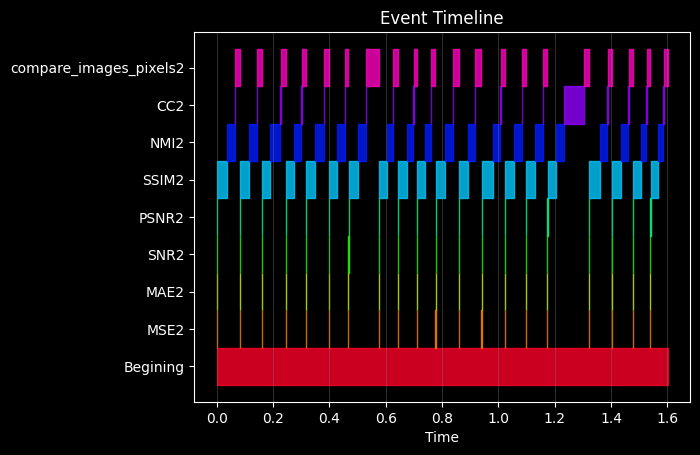

In [124]:
avg_loss_mse = []
avg_loss_mae = []
avg_loss_snr = []
avg_loss_psnr = []
avg_loss_ssim = []
avg_loss_nmi = []
avg_loss_cc = []
avg_loss_true_positive_xy = []
avg_loss_true_positive_tof = []
avg_loss_false_positive_xy = []
#avg_loss_false_negative_xy = []

#Test the function
torch.manual_seed(196)

clean_input_batch = torch.rand((16, 1, 128, 88))
noised_target_batch = torch.rand((16, 1, 128, 88))

timer = Execution_Timer()

timer.record_time(event_name="Begining", event_type="start")
for i in range (20):
    quantify_loss_performance(clean_input_batch, noised_target_batch, 1)
timer.record_time(event_name="Begining", event_type="stop")

timer.return_plot(dark_mode=True)
print(timer.return_times())

print(avg_loss_mse)
print(avg_loss_mae)
print(avg_loss_snr)
print(avg_loss_psnr)
print(avg_loss_ssim)
print(avg_loss_nmi)
print(avg_loss_cc)
print(avg_loss_true_positive_xy)
print(avg_loss_true_positive_tof)
print(avg_loss_false_positive_xy)
#print(avg_loss_false_negative_xy)


Event: Begining, Average time: 1.6797302999912063, Total time: 1.6797302999912063
Event: MSE, Average time: 0.00010894218767134589, Total time: 0.034861500054830685
Event: MAE, Average time: 0.00010837093759619165, Total time: 0.03467870003078133
Event: SNR, Average time: 0.00014978437484387542, Total time: 0.04793099995004013
Event: PSNR, Average time: 0.00011441031278991431, Total time: 0.03661130009277258
Event: SSIM, Average time: 0.0009499650005636795, Total time: 0.30398880018037744
Event: NMI, Average time: 0.002162883749724642, Total time: 0.6921227999118855
Event: CC, Average time: 0.00037254781291267135, Total time: 0.11921530013205484
Event: Compare Images, Average time: 0.0012231653123762954, Total time: 0.3914128999604145
Event: AVERAGING PROCESSING, Average time: 0.00021398499884526246, Total time: 0.004279699976905249
None
[0.16600028425455093, 0.16600028425455093, 0.16600028425455093, 0.16600028425455093, 0.16600028425455093, 0.16600028425455093, 0.16600028425455093, 0.

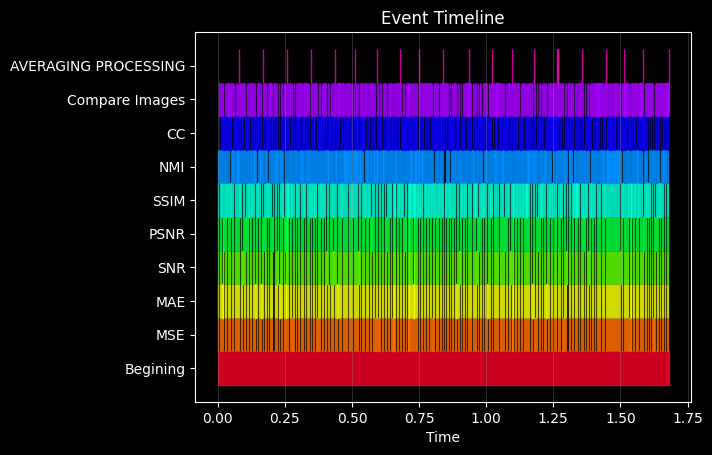

In [125]:
avg_loss_mse = []
avg_loss_mae = []
avg_loss_snr = []
avg_loss_psnr = []
avg_loss_ssim = []
avg_loss_nmi = []
avg_loss_cc = []
avg_loss_true_positive_xy = []
avg_loss_true_positive_tof = []
avg_loss_false_positive_xy = []
#avg_loss_false_negative_xy = []

#Test the function
#torch.manual_seed(196)
#clean_input_batch = torch.rand((4, 1, 256, 256))
#noised_target_batch = torch.rand((4, 1, 256, 256))

timer = Execution_Timer()


timer.record_time(event_name="Begining", event_type="start")
for i in range (20):
    quantify_loss_performanceOLD(clean_input_batch, noised_target_batch, 1)
timer.record_time(event_name="Begining", event_type="stop")

timer.return_plot(dark_mode=True)
print(timer.return_times())


print(avg_loss_mse)
print(avg_loss_mae)
print(avg_loss_snr)
print(avg_loss_psnr)
print(avg_loss_ssim)
print(avg_loss_nmi)
print(avg_loss_cc)
print(avg_loss_true_positive_xy)
print(avg_loss_true_positive_tof)
print(avg_loss_false_positive_xy)
#print(avg_loss_false_negative_xy)


In [126]:
#use timit to quantify speed of both methods
import timeit

print(timeit.timeit("quantify_loss_performance(clean_input_batch, noised_target_batch, 100)", globals=globals(), number=30))

print(timeit.timeit("quantify_loss_performanceOLD(clean_input_batch, noised_target_batch, 100)", globals=globals(), number=30))

2.024625099991681
2.30818680000084


# Start 
1.5018434999947203
1.4843086000037147






In [127]:
clean_input_batch1 = torch.rand((4, 1, 256, 256))
noised_target_batch1 = torch.rand((4, 1, 256, 256))

clean_input_batch2 = torch.rand((4, 1, 256, 256))
noised_target_batch2 = torch.rand((4, 1, 256, 256))

In [128]:
comb = torch.cat((clean_input_batch1, clean_input_batch2), 0)
com_noise = torch.cat((noised_target_batch1, noised_target_batch2), 0)


print(comb.shape)
print(com_noise.shape)

print(MAE2(comb, com_noise))


torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
0.33251312375068665


In [129]:
print(np.mean((MAE2(clean_input_batch1, noised_target_batch1), MAE2(clean_input_batch2, noised_target_batch2))))

0.33251313865184784
